<font size="5">**<center>Password Strength Classifier**</font>

# Introduction

This project aims to develop a machine-learning model that classifies the strength of a password.

# Business Problem

Password strength is a measure of the effectiveness of a password against guessing or brute-force attacks. In its usual form, it estimates how many trials an attacker who does not have direct access to the password would need, on average, to guess it correctly. The strength of a password is a function of length, complexity, and unpredictability. Using strong passwords lowers the overall risk of a security breach. Therefore, this topic is relevant to all firms that require users to use passwords to access their systems. 

# Dataset

To achieve the objective of this project, the ‘Password Strength Classifier’ dataset will be used. This data can be found at the following location:

https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset/data

The dataset has two columns: password and strength.  The password column consists of unique passwords collected online. The strength column consists of three values (0,1,2) for weak, medium, and strong, respectively.


# Libraries

In [1]:
# Import the necessary library.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix,accuracy_score,precision_score,recall_score,f1_score)
import pickle
import warnings
warnings.filterwarnings("ignore")

# Data Exploration 

In [2]:
## Loading the data
passwords_df =pd.read_csv("data.csv",on_bad_lines='skip')

In [3]:
# Checking first five observations
passwords_df.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


The above output shows the first five rows and all the features of the dataset. All features appear to be populated.

In [4]:
# Checking last five observations
passwords_df.tail()

,password,strength
669635,10redtux10,1
669636,infrared1,1
669637,184520socram,1
669638,marken22a,1
669639,fxx4pw4g,1


The above output shows the last five rows and all the features of the dataset. All features appear to be populated.

In [5]:
# Checking the information of the dataset
passwords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669640 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669640 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ MB


The data has two columns and their types make sense. The non-null count shows there is one missing value in the password column.

## Checking missing values and treatment

In [6]:
#Checking missing values.
passwords_df.isna().sum().to_frame(name = 'Number of missing value')

,Number of missing value
password,1
strength,0


The strength column has no missing value, but the password column has a missing value. The missing value will be removed below.

In [7]:
# Dropping missing values
passwords_df.dropna(how='any', inplace=True)

In [8]:
# Rechecking if missing values were successfully dropped.
passwords_df.isna().sum().to_frame(name = 'Number of missing value')

,Number of missing value
password,0
strength,0


As shown above the missing value has been dropped.

## Checking duplicate rows and treating them.

In [9]:
# Checking number of duplicates reviews and score.
duplicates = passwords_df.duplicated(subset=['password','strength'], keep='first').sum()
print("Number of duplicates which should be removed: ", duplicates)

Number of duplicates which should be removed:  0


The are no duplicates in the dataset.

## Analyzing the characteristics of the passwords

In [10]:
# Find the length of characters presented in password
passwords_df['char_count'] = passwords_df['password'].str.len()

# Find the length of numbers presented in password
passwords_df['numerics'] = passwords_df['password'].apply(lambda x: len([str(x) for x in list(x) if str(x).isdigit()]))

# Find the length of alphabetical letters presented in password
passwords_df['letters'] = passwords_df['password'].apply(lambda x: len([x for x in list(x) if x.isalpha()]))

# Find the length of puncuations presented in password
specialSymbols = '!?%&.:~/\|,;<>-_+@#$%^&*(){}[]'
passwords_df['punc'] = passwords_df['password'].apply(lambda x: len([x for x in list(x) if x in specialSymbols]))

# Find the length of vowels presented in password
vowels = ['a', 'e', 'i', 'o', 'u']
passwords_df['vowels'] = passwords_df['password'].apply(lambda x: len([x for x in list(x) if x in vowels]))

# Find the length of consonants presented in password
passwords_df['consonants'] = passwords_df['password'].apply(lambda x: len([x for x in list(x) if x not in vowels and x.isalpha()]))

passwords_df.head()

,password,strength,char_count,numerics,letters,punc,vowels,consonants
0,kzde5577,1,8,4,4,0,1,3
1,kino3434,1,8,4,4,0,2,2
2,visi7k1yr,1,9,2,7,0,2,5
3,megzy123,1,8,3,5,0,1,4
4,lamborghin1,1,11,1,10,0,3,7


## Outlier Analysis and treatment

Inter Quartile Range(IQR) approach to finding the outliers is the most commonly used and most trusted approach used in the research field.  It first computes the first quartile (Q1) and third quartile (Q3), then calculates the IQR as the difference between Q3 and Q1, providing a measure of the spread of the middle 50% of the data in the variable under consideration. An outlier is any observation outside +/- 1.5IQR.

In [11]:
# Creating a copy of the dataframe
passwords_df_copy = passwords_df.copy()

In [12]:
# Extracting Features numeric features.
numeric_df = passwords_df_copy.select_dtypes(exclude=object)
numeric_features = list(numeric_df.columns)
numeric_features = numeric_features[1:]
print(numeric_features)
print(' ')
print('The dataset has ',len(numeric_features),'numeric columns.')

['char_count', 'numerics', 'letters', 'punc', 'vowels', 'consonants']
 
The dataset has  6 numeric columns.


- Detecting Outliers

In [13]:
def check_outliers(dataframe,variables):
    """ This function creates boxplots which are used to detect outliers."""
    title_string = "Detecting outliers using boxplots"
    plt.figure(figsize=(9,9))
    for n, variable in enumerate(variables):
        
        # add a new subplot iteratively
        ax = plt.subplot(int(len(variables)/2), 2, n + 1)
        
        # plotting the boxplots on the subplot axis
        plt.boxplot(dataframe[variable],vert=False)
        
        # chart formatting
        ax.set_title(variable.lower())
        
        ax.set_xlabel("")
        plt.subplots_adjust(bottom=0.000001,wspace=0.4, hspace=0.4)  
        plt.suptitle(title_string, y=.95, fontsize=14)

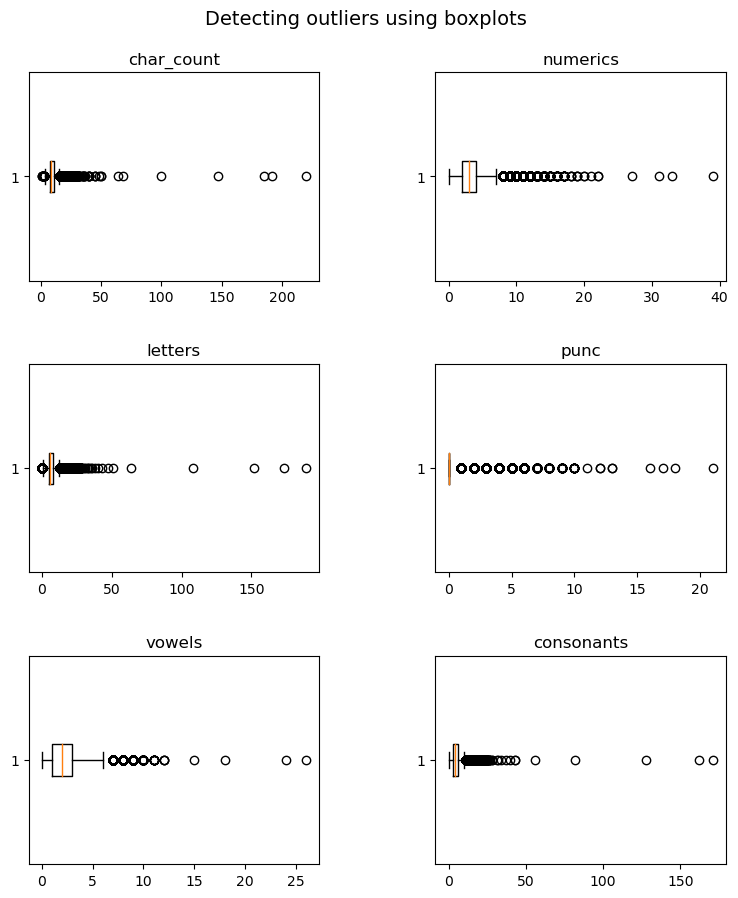

In [14]:
check_outliers(passwords_df_copy, numeric_features)

The boxplots above show that there are some variables with outliers. Outliers will be quantitatively identified below.

- Removing outliers

In [15]:
def outliers(dataframe,variable):
    ''' Function to quantitatively identify outliers'''
    # Calculate the Upper(Q3) and Lower(Q1) limits
    Q1  = dataframe[variable].quantile(0.25)
    Q3  = dataframe[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
        
    # List to creat indexes of outliers
    list_of_outliers = dataframe.index[(dataframe[variable] < lower)
                                       |(dataframe[variable]> upper)]
    return list_of_outliers  

In [16]:
# Create Empty list to store the output indices for outliers
index_list =[]
for feature in numeric_features:
    index_list.extend(outliers(passwords_df_copy,feature))

In [17]:
def remove(dataframe,list_of_outliers):
    ''' Function to remove outliers from a dataframe'''
    list_of_outliers = sorted(set(list_of_outliers ))
    dataframe =  dataframe.drop(list_of_outliers)
    return dataframe

In [18]:
# Removing outliers from the dataset and creating a dataframe free from outliers
passwords_cleaned_df = remove(passwords_df_copy, index_list)

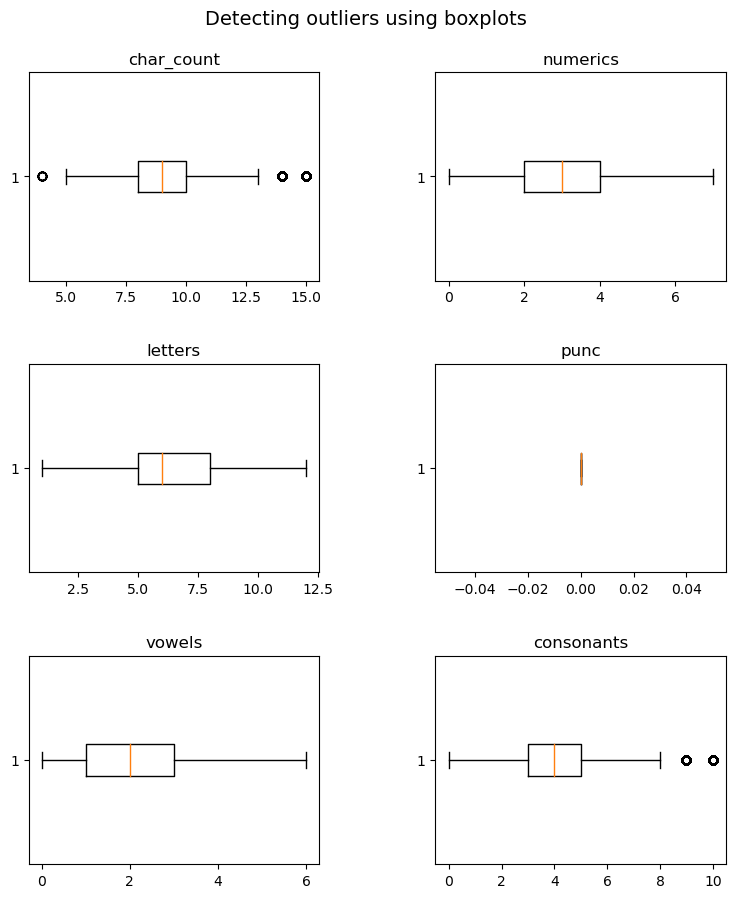

In [19]:
# Checking outliers again after removal
check_outliers(passwords_cleaned_df, numeric_features)

The boxplot above show the features without outliers.

In [20]:
# Shape of dataframe with outliers
passwords_df_copy.shape

(669639, 8)

In [21]:
# Shape of dataframe without outliers
passwords_cleaned_df.shape

(559859, 8)

Outlier removal was successful since the observations in the new dataframe is lower than the original dataframe. The dataframe without outliers will be used to build the model.

# Data Visualization

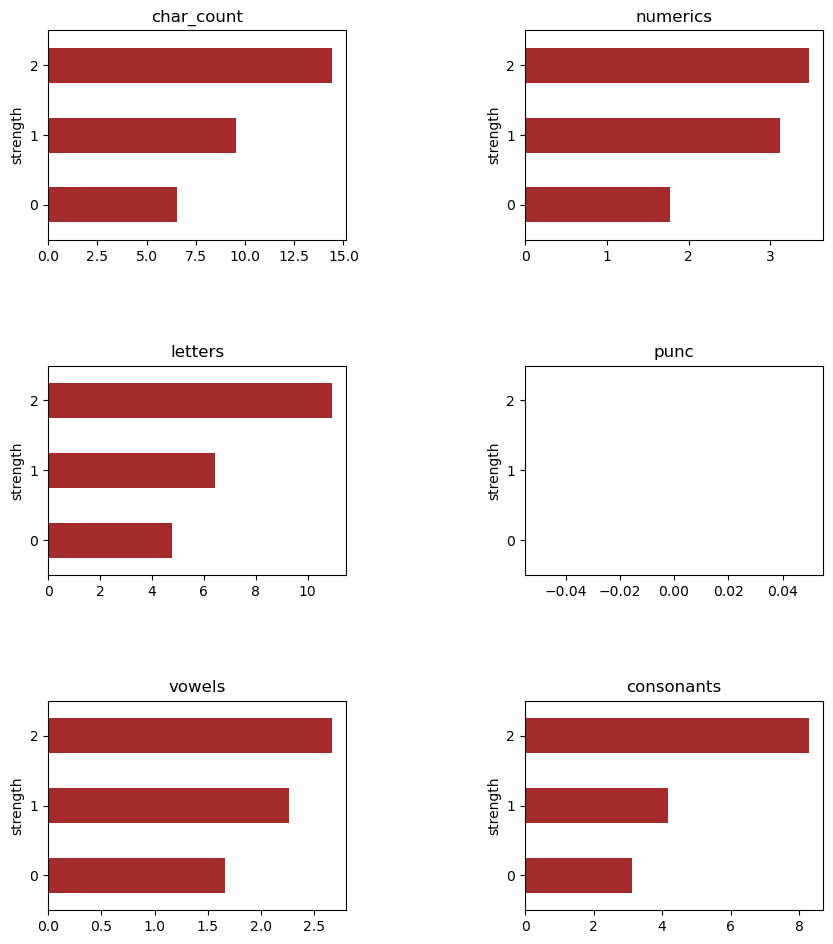

In [22]:
plt.figure(figsize=(10,10))
for n, feature in enumerate(numeric_features):
    # Calculating average of each numeric variable
    average = passwords_cleaned_df.groupby(['strength'])[feature].mean()
    # add a new subplot iteratively
    ax = plt.subplot(int(len(numeric_features)/2), 2, n + 1)
        
    # plotting the boxplots on the subplot axis
    average.plot(kind='barh',color='brown')
        
     # chart formatting
    ax.set_title(feature.lower())
        
    ax.set_xlabel("")
    plt.subplots_adjust(bottom=0.000001,wspace=0.6, hspace=0.6)  
   # plt.suptitle(title_string, y=.95, fontsize=14)

As shown above strong passwords(2), had the highest number of characters, digits, letters, vowels and consonants followed by mediumn passwords and then week passwords. No password has punctuation marks.

## Target variable distribution

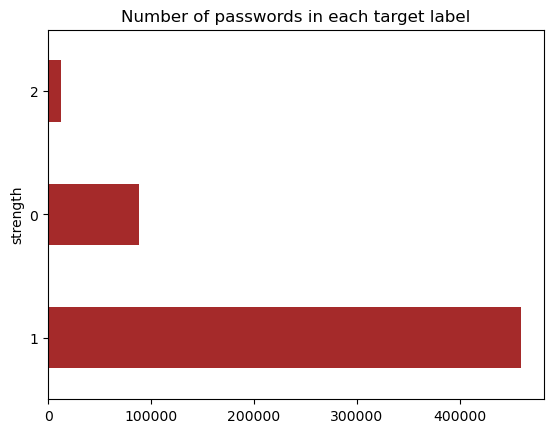

In [23]:
# Creating the the distribution of the target variable
counts = passwords_cleaned_df['strength'].value_counts()

# Plotting the target categories 
counts.plot(kind='barh', title="Number of passwords in each target label",
            color = 'brown');

The bar chart shows that passwords of medium strength(1) are in the majority compared stong(2) and weak passwords. Therefore, a model built using this data is likely to do a better job at predicting medium passwords than strong or weak passwords.

# Model Building

## Data partition

An 80/20 percent split will be used to partition the data in order to have more data in the training set.

In [24]:
# Extracting features from the dataset.
features = passwords_cleaned_df.iloc[:,2:8]

# Extracting the target from the dataset.
target = passwords_cleaned_df.iloc[:,1]

In [25]:
# Splitting data into training and test sets.
train_features, test_features,train_target,test_target = train_test_split(features, 
                                                                          target, 
                                                                          test_size=0.2,
                                                                          random_state=1,
                                                                          stratify=target)

## Training

In [26]:
# Creating function to train the model and output performance metrics
def train_and_evaluation(model, training_features, training_target, testing_features, testing_target):

    # training the model
    _ = model.fit(training_features, training_target)

    # Generating Predictions on training and testing sets.
    preds_on_train = model.predict(training_features)
    preds_on_test = model.predict(testing_features)

    # Model performance evaluation o
    print()
    print(model)
    print(f"Accuracy score on training set : {round(accuracy_score(training_target, preds_on_train),4)*100}","%")
    print(f"Accuracy score on testing set  : {round(accuracy_score(testing_target, preds_on_test),4)*100}","%")
    print(f"F - 1 score on training set    : {round(f1_score(training_target, preds_on_train, average='macro'),4)*100}","%")
    print(f"F - 1 score on testing set     : {round(f1_score(testing_target, preds_on_test,  average='macro'),4)*100}","%")
    print('\n',60*'-')

### Logistic Regression

In [27]:
# Creating hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

# Looping through each hyperparameter and creating a model for each.
for c in C: 
    # Defining logistic regression model object
    lr_model = LogisticRegression(C=c, max_iter=10000, random_state=1, multi_class='multinomial', solver='newton-cg')
    
    # Training and evaluating the logistic regression model
    train_and_evaluation(model=lr_model,
                         training_features=train_features,
                         training_target=train_target,
                         testing_features=test_features,
                         testing_target=test_target)


LogisticRegression(C=0.001, max_iter=10000, multi_class='multinomial',
                   random_state=1, solver='newton-cg')
Accuracy score on training set : 99.83 %
Accuracy score on testing set  : 99.81 %
F - 1 score on training set    : 98.61 %
F - 1 score on testing set     : 98.46000000000001 %

 ------------------------------------------------------------

LogisticRegression(C=0.01, max_iter=10000, multi_class='multinomial',
                   random_state=1, solver='newton-cg')
Accuracy score on training set : 100.0 %
Accuracy score on testing set  : 99.99 %
F - 1 score on training set    : 99.97 %
F - 1 score on testing set     : 99.96000000000001 %

 ------------------------------------------------------------

LogisticRegression(C=0.1, max_iter=10000, multi_class='multinomial',
                   random_state=1, solver='newton-cg')
Accuracy score on training set : 100.0 %
Accuracy score on testing set  : 100.0 %
F - 1 score on training set    : 99.99 %
F - 1 score on testin

### Naive Bayes

In [28]:
# Creating hyperparameters
alphas = [0.01, 0.2, 0.6, 0.8, 1]

# Looping through each hyperparameter and creating a model for each.
for a in alphas: 
    # Defining naive bayes model object
    nb_model = nb_model = MultinomialNB(alpha=a)
    
    # Training and evaluating the naive bayes model
    train_and_evaluation(model=nb_model,
                         training_features=train_features,
                         training_target=train_target,
                         testing_features=test_features,
                         testing_target=test_target)


MultinomialNB(alpha=0.01)
Accuracy score on training set : 82.03 %
Accuracy score on testing set  : 82.03 %
F - 1 score on training set    : 30.04 %
F - 1 score on testing set     : 30.04 %

 ------------------------------------------------------------

MultinomialNB(alpha=0.2)
Accuracy score on training set : 82.03 %
Accuracy score on testing set  : 82.03 %
F - 1 score on training set    : 30.04 %
F - 1 score on testing set     : 30.04 %

 ------------------------------------------------------------

MultinomialNB(alpha=0.6)
Accuracy score on training set : 82.03 %
Accuracy score on testing set  : 82.03 %
F - 1 score on training set    : 30.04 %
F - 1 score on testing set     : 30.04 %

 ------------------------------------------------------------

MultinomialNB(alpha=0.8)
Accuracy score on training set : 82.03 %
Accuracy score on testing set  : 82.03 %
F - 1 score on training set    : 30.04 %
F - 1 score on testing set     : 30.04 %

 ------------------------------------------------

### XGBoost Classifier

In [29]:
# Creating hyperparameters
alphas = [0, 0.2, 0.6, 0.8, 1]

# Looping through each hyperparameter and creating a model for each.
for a in alphas: 
    # Defining naive bayes model object
    xgb = XGBClassifier(alpha=a, random_state = 100, objective="multi:softprob")
    
    # Training and evaluating the naive bayes model
    train_and_evaluation(model=xgb,
                         training_features=train_features,
                         training_target=train_target,
                         testing_features=test_features,
                         testing_target=test_target)


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)
Accuracy score on training set : 100.0 %
Accuracy score on testing set  : 100.0 %
F - 1 score on training set    : 100.0 %
F - 1 score on testing set     : 100.0 %

 ------------------------------------------------------------

XGBClassifier(alpha=0.2

# Best Model 

The logistic regression models with hyperparameter c >= 0.001 and all xgboost models have the same and better performance than the Naive Bayes model. Logistic regression model with c=0.001 will be selected as the best model because it signifies stronger regularization, has high performance and does not show signs of overfitting(or perfection). Further, Logist regression was chosen over xgboost because of the following:

1. **Simplicity** is one of the advantages. Simple and easily understood, logistic regression is a model. It can help to comprehend the connection between characteristics and the target variable and offers a clear interpretation of coefficients.

2. **Efficacy** : Large datasets with many features can benefit from the computational efficiency of logistic regression with gradient descent. It can be trained effectively on distributed computing platforms and has rather low memory needs.

3. **Linear Relationships** : Logistic regression works well with issues in which the target variable and features have a roughly linear relationship. It is able to reliably anticipate in such situations and capture linear relationships.


## Additional evaluation of best model

In [30]:
# Function to plot confusion metrix
def conf_matrix(actual,predictions):
    " This function calculates the accuracy score and displays it on the confusion matrix"
    # Calculating accuracy score
    score = round(accuracy_score(actual,predictions),4)*100
    
    # Creating confusion matrix.
    confusion_matrix = metrics.confusion_matrix(actual, predictions,normalize='true')
    
    # Displaying confusion matrix.
    plt.figure(figsize=(5,5))
    labels=['password-weak', 'password-Medium','password-Strong']
    sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'twilight',
               xticklabels=labels, yticklabels=labels);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score as a % : {0}'.format(score)
    plt.title(all_sample_title, size = 10);

In [31]:
# refitting the best model.
best_model = LogisticRegression(C=0.001, max_iter=10000, random_state=1)
best_model.fit(train_features,train_target)

LogisticRegression(C=0.001, max_iter=10000, random_state=1)

In [32]:
# Generating predictions
predictions_train = best_model.predict(train_features)
predictions_test = best_model.predict(test_features)

In [33]:
# Checking the accuracy
print(f"Train accuracy score : {accuracy_score(train_target, predictions_train)}")
print(f"Test accuracy score : {accuracy_score(test_target, predictions_test)}")

Train accuracy score : 0.9982584893064546
Test accuracy score : 0.9980798771121352


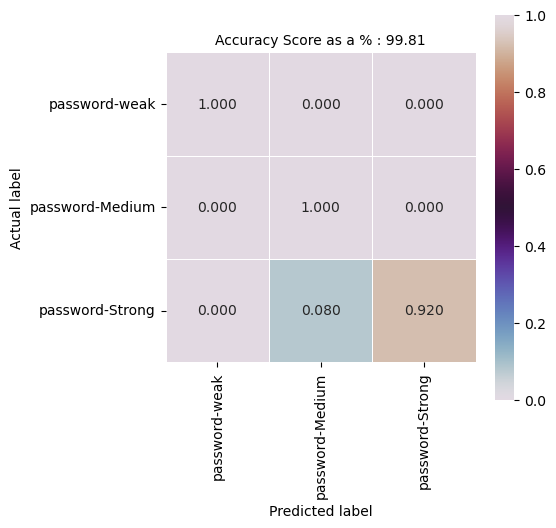

In [34]:
conf_matrix(test_target,predictions_test)

The model is doing a good job in predicting all class labels. Notably, it performance on strong password is slightly lower that on medium and weak passwords. This is because number of strong passwords is lower than the number of medium and weak passwords in the training data.

## Testing the model with a sample passwords

In [35]:
# Function to preprocess the password.
def password_preprocessor(text):
  # Find the length of character presented in password
  char_count=len(text)
  text=pd.Series(text)
  # # Find the length of number presented in password
  numerics=text.apply(lambda x: len([str(x) for x in list(x) if str(x).isdigit()]))
  # # Find the length of Alphabets presented in password
  letters=text.apply(lambda x: len([x for x in list(x) if x.isalpha()]))
  # # Find the length of puncuation presented in password
  specialSymbols = '!?%&.:~/\|,;<>-_+@#$%^&*(){}[]'
  punc=text.apply(lambda x: len([x for x in list(x) if x in specialSymbols]))
  # # Find the length of vowels presented in password
  vowels = ['a', 'e', 'i', 'o', 'u']
  vowels=text.apply(lambda x: len([x for x in list(x) if x in vowels]))
  # # Find the length of consonants presented in password
  consonants=text.apply(lambda x: len([x for x in list(x) if x not in vowels and x.isalpha()]))
  return char_count,numerics[0],letters[0],punc[0],vowels[0],consonants[0]

    Test 1 - First Password

In [36]:
# Calculation the number of characters, numerics, letters, puctuations, vowels and consonants.
length=password_preprocessor('KA1995*$;')

In [37]:
# Putting the number of characters, numerics, letters, puctuations, vowels and consonants in a dataframe.
data =pd.DataFrame({'char_count':  [length[0]],
        'numerics': [length[1]],
        'letters':  [length[2]],
        'punc':  [length[3]],
        'vowels':  [length[4]],
        'consonants':  [length[5]]
        })

In [38]:
# Generating  the prediction
k=best_model.predict(data)
if k ==0:
  print('Password Strength is weak')
elif k==1:
  print('Password Strength is medium')
else:
  print('Password Strength is strong')

Password Strength is medium


    Test 2 - Second password

In [39]:
# Calculation the number of characters, numerics, letters, puctuations, vowels and consonants.
length=password_preprocessor('#Nampungwekps1988')

In [40]:
# Putting the number of characters, numerics, letters, puctuations, vowels and consonants in a dataframe.
data =pd.DataFrame({'char_count':  [length[0]],
        'numerics': [length[1]],
        'letters':  [length[2]],
        'punc':  [length[3]],
        'vowels':  [length[4]],
        'consonants':  [length[5]]
        })

In [41]:
# Generating  the prediction
k=best_model.predict(data)
if k ==0:
  print('Password Strength is weak')
elif k==1:
  print('Password Strength is medium')
else:
  print('Password Strength is strong')

Password Strength is strong


    Test 3 - Third Password 

In [42]:
length = password_preprocessor('Imwe')

In [43]:
# Putting the number of characters, numerics, letters, puctuations, vowels and consonants in a dataframe.
data =pd.DataFrame({'char_count':  [length[0]],
        'numerics': [length[1]],
        'letters':  [length[2]],
        'punc':  [length[3]],
        'vowels':  [length[4]],
        'consonants':  [length[5]]
        })

In [44]:
# Generating  the prediction
k=best_model.predict(data)
if k ==0:
  print('Password Strength is weak')
elif k==1:
  print('Password Strength is medium')
else:
  print('Password Strength is strong')

Password Strength is weak


## Saving the model for deployment

In [45]:
# Saving the model as pickle file for deployment
with open("password_classifier.pkl", "wb") as f:
    pickle.dump(best_model, f)